# Dependencies

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
import gradio as gr
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and Reshape

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1) #We have to pass a 4D array to a CNN
print("y_train shape:", y_train.shape)
print("y_train unique values:", np.unique(y_train))
print("Min pixel:", x_train.min(), "Max pixel:", x_train.max())

y_train shape: (60000,)
y_train unique values: [0 1 2 3 4 5 6 7 8 9]
Min pixel: 0.0 Max pixel: 1.0


# Model Setup

In [6]:
#Set up the model:
model_cnn = Sequential([
    tf.keras.Input(shape=(28,28,1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(10, activation='linear')
])

In [7]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897,802 (3.42 MB)

 Trainable params: 897,354 (3.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
model_cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

#Data Argumentation & Fitting

In [10]:

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

datagen.fit(x_train)

history_with_distortion = model_cnn.fit(datagen.flow(x_train, y_train, batch_size=128),
          validation_data=(x_val, y_val),
          epochs=15)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.8310 - loss: 0.8002 - val_accuracy: 0.9447 - val_loss: 0.3396
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9670 - loss: 0.2514 - val_accuracy: 0.9907 - val_loss: 0.1449
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9757 - loss: 0.1822 - val_accuracy: 0.9863 - val_loss: 0.1323
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9772 - loss: 0.1599 - val_accuracy: 0.9898 - val_loss: 0.1132
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9781 - loss: 0.1505 - val_accuracy: 0.9922 - val_loss: 0.1014
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9815 - loss: 0.1325 - val_accuracy: 0.9932 - val_loss: 0.0892
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9816 - loss: 0.1259 - val_accuracy: 0.9907 - val_loss: 0.1019
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9824 - loss: 0.1249 - 

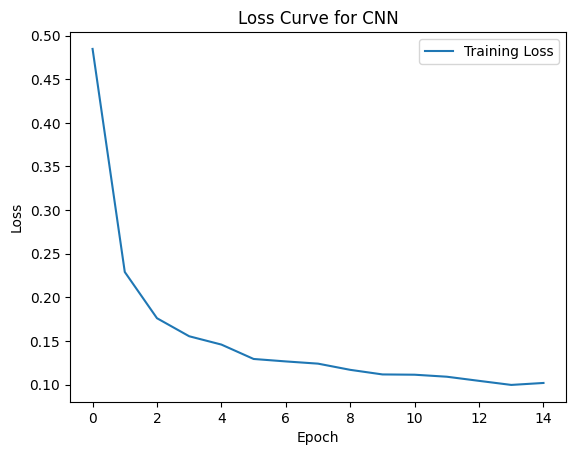

In [11]:
plt.plot(history_with_distortion.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve for CNN')
plt.show()

In [16]:
model_cnn.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9924 - loss: 0.0764


[0.0738803818821907, 0.9937000274658203]